## Bigram model (base statistical model)

In [1]:
# understand the training dataset words (file of names)


words = open("/home/yucongguo/names.txt",'r').read().splitlines()
display(words[:10])
print("length of word:",len(words),"\n")
print("minimun length of word:", min([len(w) for w in words]),"\n")
print("max length of word:", max([len(w) for w in words]),"\n")

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

length of word: 32033 

minimun length of word: 2 

max length of word: 15 



In [2]:
# understand the structure of names
# bigram model : look at previous 2 characters and predict the next character, look at statistical number

b = {}
for w in words:
    # create special start and end character
    w = ["<S>"] + list(w) + ["<E>"] 
    for ch1, ch2 in zip(w,w[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0) + 1

b = sorted(b.items(), key = lambda key_value: -key_value[1])

#example of b
print(b[:5])


[(('n', '<E>'), 6763), (('a', '<E>'), 6640), (('a', 'n'), 5438), (('<S>', 'a'), 4410), (('e', '<E>'), 3983)]


In [3]:
import torch

I0117 132848.823 _utils_internal.py:231] NCCL_DEBUG env var is set to None


I0117 132848.824 _utils_internal.py:249] NCCL_DEBUG is forced to WARN from None


In [4]:
N = torch.zeros((27,27), dtype = torch.int32) #since there are 26 character and two sepcial start and end character

In [5]:
# construct the same bigram model using torch 

chars = sorted(list(set(''.join(words))))
str_to_int = {s:i+1 for i,s in enumerate(chars)}
str_to_int['.']  = 0

int_to_str = {i+1:s for i,s in enumerate(chars)}
int_to_str[0]  = '.'


for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w,w[1:]):
        x1 = str_to_int[ch1]
        x2 = str_to_int[ch2]
        N[x1,x2] += 1

I0117 132902.525 font_manager.py:1349] generated new fontManager


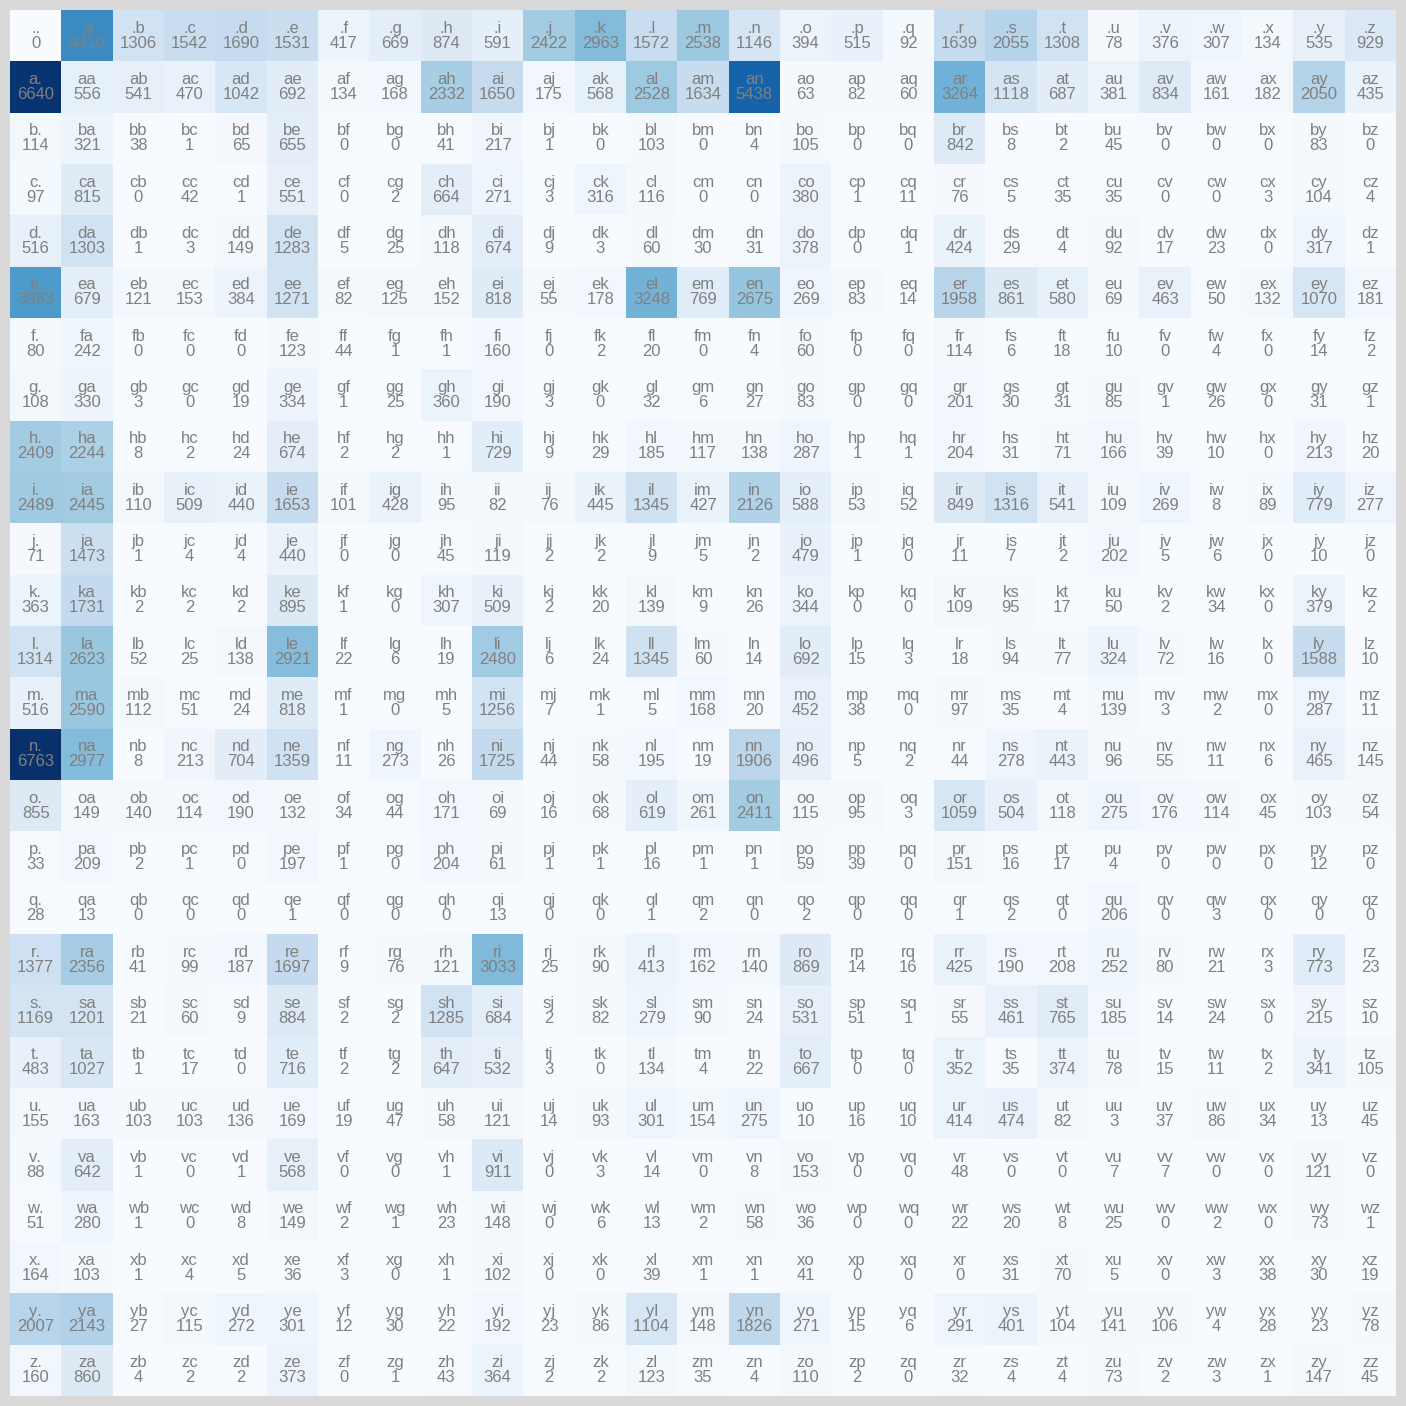

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18,18))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = int_to_str[i] + int_to_str[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [7]:
#example:  prob of start a word
prob = N[0].float()
prob = prob / prob.sum()
prob

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [8]:
# define probality torch matrix

P = N.float()
P /= P.sum(1, keepdims=True)

print(P[0].sum())

tensor(1.)


In [53]:
# generate names using bigram model

g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    index = 0
    out = []
    while True:
        p = P[index]
        index = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(int_to_str[index])
        if index == 0:
            break
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


# Neural network of bigram model

In [10]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [11]:
# illustration

log_likelihood = 0
count = 0

for w in words[:3]:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w,w[1:]):
        x1 = str_to_int[ch1]
        x2 = str_to_int[ch2]
        prob = P[x1,x2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        count += 1

        print(f'probability of {ch1}{ch2}: {prob:.4f}')
neg_log_likelihood = -log_likelihood
 
print (f"\nlog_likelihood: {log_likelihood}")
print (f"\nneg_log_likelihood: {neg_log_likelihood}")
print (f"\nnormalized neg_log_likelihood: {neg_log_likelihood / count}")

print("\ngoal: find the best parameter of probability to minimize the neg_log_likelihood")


probability of .e: 0.0478
probability of em: 0.0377
probability of mm: 0.0253
probability of ma: 0.3899
probability of a.: 0.1960
probability of .o: 0.0123
probability of ol: 0.0780
probability of li: 0.1777
probability of iv: 0.0152
probability of vi: 0.3541
probability of ia: 0.1381
probability of a.: 0.1960
probability of .a: 0.1377
probability of av: 0.0246
probability of va: 0.2495
probability of a.: 0.1960

log_likelihood: -38.78563690185547

neg_log_likelihood: 38.78563690185547

normalized neg_log_likelihood: 2.424102306365967

goal: find the best parameter of probability to minimize the neg_log_likelihood


In [12]:
# create the tranining set of bigram

x ,y = [],[] # x: input, y: target

for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w,w[1:]):
        x1 = str_to_int[ch1]
        x2 = str_to_int[ch2]
        x.append(x1)
        y.append(x2)

x = torch.tensor(x)
y = torch.tensor(y)
display(x[:5])
display(y[:5])

print("idea: when see 0, want to see the label (prediction) to be 5\n")
print("idea: when see 5, want to see the label (prediction) to be 13\n")
print("so find the best parameter of probability")

tensor([ 0,  5, 13, 13,  1])

tensor([ 5, 13, 13,  1,  0])

idea: when see 0, want to see the label (prediction) to be 5

idea: when see 5, want to see the label (prediction) to be 13

so find the best parameter of probability


nerual network\
input layer: 27 neural, output layer: 27 neural

In [42]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad= True)

In [50]:
#forward pass / softmax
import torch.nn.functional as F

for k in range(500):

    #forward pass
    x_encod = F.one_hot(x, num_classes = 27).float() # convert each x into torch(1,27)
    log_counts = x_encod @ W # matrix multiplication (x,27) @ (27,27) = (x,27)

    #softmax
    counts  = log_counts.exp()
    probs = counts / counts.sum(1, keepdims=True)

    #loss
    loss = - probs[torch.arange(len(x_encod)),y].log().mean() + 0.01 * (W**2).mean() #negative log likelihood and regularization
    
    # backward pass
    W.grad = None
    loss.backward()

    #update
    W.data += -50 * W.grad


In [57]:
# make prediction
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  index = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([index]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    index = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(int_to_str[index])
    if index == 0:
      break
  print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.


note that stastital bigram model and neural network bigram model give the same result  